In [2]:
import os
import json
import pandas as pd
import datetime
import dateutil.parser
import numpy as np
import tweepy
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib as plt

pd.options.display.max_colwidth = 280
stop_words = nltk.corpus.stopwords.words('english')
stop_words.append('')


In [3]:
def authenticate_api():
    auth = tweepy.OAuth1UserHandler(
        os.getenv('CONSUMER_KEY'), os.getenv('CONSUMER_SECRET'),
        os.getenv('ACCESS_TOKEN'), os.getenv('ACCESS_SECRET')
    )
    api = tweepy.API(auth)
    return api

In [4]:
def extract_dict(tweet_json):
    tweet_dict = {}
    for user_col in ['id', 'name', 'location', 'followers_count']:
        tweet_dict['user_' + user_col] = [tweet_json['user'][user_col]]
    for col in ['created_at', 'id', 'retweet_count', 'favorite_count', 'lang', 'in_reply_to_user_id', 'full_text']:
        tweet_dict[col] = [tweet_json[col]]
    return tweet_dict

In [5]:
def get_nltk_sentiment(sia, text):
    return sia.polarity_scores(text)['compound']

In [6]:
def clean_tweet(words):
    words = words.replace('-', ' ').replace('\n', ' ').replace('%', ' percent')
    words = re.sub(r"RT @(.*?):", "", words)  # remove RT
    words = re.sub(r"https.*?([\s\n])", "", words)  # remove url
    http_loc = words.find('https')
    if http_loc > 0:
        return words[0:http_loc-1]  # remove url at end of tweet
    if http_loc == 0:
        return ''
    return words

In [7]:
def tokenize(words):
    tokens = re.split('\W+', words.lower())
    return [w for w in tokens if w not in stop_words]

In [8]:
def remove_punctuation(words):
    return "".join([w for w in words if w not in string.punctuation])

In [9]:
def get_df(tweets, add_sentiment=True):
    dfs = []
    for tweet in tweets:
        dfs.append(pd.DataFrame(extract_dict(tweet._json)))
    if len(dfs) == 0:
        return pd.DataFrame()
    df = pd.concat(dfs)
    df['clean_tweet'] = df['full_text'].apply(lambda x: clean_tweet(x))
    df['tokens'] = df['clean_tweet'].apply(lambda x: tokenize(remove_punctuation(x)))
    
    if add_sentiment:
        sia = SentimentIntensityAnalyzer()
        df['positivity'] = df['clean_tweet'].apply(lambda x: get_nltk_sentiment(sia, x))
    return df.reset_index(drop=True)

In [10]:
api = authenticate_api()

In [33]:
tweets = api.home_timeline(count=100, exclude_replies=False, include_entities=False, tweet_mode='extended')
tweet_df = get_df(tweets)
#tweet_df

# NYT = 807095, Economist = 5988062, WSJ = 3108351, Onion = 14075928

## Classifying NYT and Onion tweets
1. Pull the most recent 1000 unique, english-language tweets from each of the Onion and the NYT
2. Calculate inverse document frequency to identify rare words
3. Use random forest to classify on the IDF matrix
4. Check confusion matrix for performance
5. See examples of misclassifications

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [12]:
def extract_user_timeline(user_id, count=100, add_sentiment=True):
    # return number of unique tweets equal to count from this user_id
    t1 = datetime.datetime.now()
    df = pd.DataFrame()
    max_id = None
    while df.shape[0] < count:
        temp = get_df(api.user_timeline(user_id=user_id, include_rts=False, tweet_mode='extended', max_id=max_id),
                      add_sentiment=add_sentiment)
        if temp.empty:
            print('CANNOT reach count of {0}. Terminated at count={1}.'.format(count, num_tweets))
            return pd.concat(dfs).reset_index(drop=True).drop_duplicates(subset='clean_tweet', keep='first')
        max_id = temp.iloc[-1]['id']-1
        df = pd.concat([df, temp]).reset_index(drop=True)
        df = df[df['lang'] == 'en'].drop_duplicates(subset='clean_tweet', keep='first')
        #print(f'df shape={df.shape[0]}, max_id={max_id}')
    t2 = datetime.datetime.now()
    print(t2-t1)
    return df

In [13]:
onion = extract_user_timeline(14075928, count=1000, add_sentiment=False)

0:00:20.255740


In [14]:
nyt = extract_user_timeline(807095, count=1000, add_sentiment=False)

0:00:20.676223


In [15]:
onion['label'] = 'satire'
nyt['label'] = 'news'

In [16]:
news_df = pd.concat([onion[['label','full_text']], nyt[['label','full_text']]]).reset_index(drop=True)

In [17]:
# tf idf
def prep_inv_doc(x):
    return tokenize(remove_punctuation(clean_tweet(x)))

inv_doc = TfidfVectorizer(analyzer=prep_inv_doc)
inv_doc_output = inv_doc.fit_transform(news_df['full_text'])
id_df = pd.DataFrame(inv_doc_output.toarray())

In [18]:
X_train, X_test, y_train, y_test = train_test_split(id_df, news_df['label'], test_size=0.3)

In [19]:
rf_to_fit = RandomForestClassifier()
rf = rf_to_fit.fit(X_train, y_train)

In [20]:
y_pred = rf.predict(X_test)

0.8498583569405099
0.9463722397476341


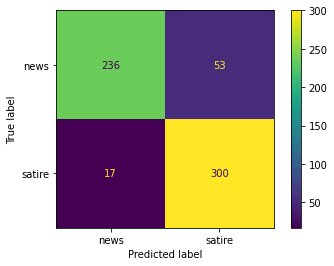

In [21]:
cm = confusion_matrix(y_test, y_pred, labels=['news', 'satire'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['news', 'satire'])
disp.plot()

precision = precision_score(y_test, y_pred, pos_label='satire')
print(precision)
recall = recall_score(y_test, y_pred, pos_label='satire')
print(recall)

In [22]:
misclass = news_df.merge(y_test[y_test != y_pred], left_index=True, right_index=True, how='inner')
misclass[misclass['label_y'] == 'satire'].head()

,label_x,full_text,label_y
27,satire,Something Called ‘Guacamole Donut’ Burying News Of Dozens Of School Shootings https://t.co/TacilAGlyC https://t.co/jUhmf2hRV9,satire
274,satire,Trump Outmaneuvers New York Lawsuit By Changing Name To Donald 2 https://t.co/gNkqqyMnN6 https://t.co/0kV0AbBtna,satire
279,satire,"This November, Trump-loyalist and former television news anchor Kari Lake will be on the ballot in the Arizona governor’s race. The Onion asked Arizonans why they are voting for the Republican candidate, and this is what they said. https://t.co/R4388Z1pKv",satire
303,satire,"This November, state senator and Christian nationalist Doug Mastriano will be on the ballot in the Pennsylvania governor’s race. The Onion asked Pennsylvanians why they are voting for the Republican candidate, and this is what they said. https://t.co/6cyXxXKMBV",satire
304,satire,"You might not know it, but many of the most famous commentators on Fox News, OAN, and Infowars actually used to work as actors, directors, and writers. Here are today’s most famous conservative faces that got their start in Hollywood. https://t.co/fiLFdlvVeu",satire


In [23]:
misclass[misclass['label_y'] == 'news'].head()

,label_x,full_text,label_y
1025,news,We welcome questions for our speakers. Here is how you can participate. https://t.co/tWowjJhBCL,news
1093,news,"Israel's lockdown of the northern West Bank, which it says is a response to a growing insurgency, has entered its third week. Palestinians in cities like Nablus have to queue for hours to leave, and with roads blocked off, the local economy has suffered. https://t.co/R9GSboSHQX",news
1094,news,"There is no explicit declaration in the U.S. Constitution that says Americans have a right to vote — something many politicians and their supporters consider fundamental to democracy. Here’s a look at why that is, and what rights voters actually have. https://t.co/kloO7kzOZF",news
1118,news,"These addictive seasoned ""fries"" are actually baked, but we promise you won't miss the grease. \nhttps://t.co/zxYRsdJF0w",news
1134,news,"A new breed of campaign aide has emerged, whose online profiles more closely resemble social media influencers than traditional behind-the-scenes press operatives. https://t.co/lmIFdpjWCX",news


**Twitter API methods**
* `get_retweeter_ids(id, *, count, cursor, stringify_ids)`
* `get_retweets`
* `get_status` 
* `search_tweets(q, *, geocode, lang, locale, result_type, count, until, since_id, max_id, include_entities)`
    * query syntax: https://developer.twitter.com/en/docs/twitter-api/v1/rules-and-filtering/search-operators
* `get_follower_ids(*, user_id, screen_name, cursor, stringify_ids, count)`
    * returns 5000 at a time
* `search_users(q, *, page, count, include_entities)`
* `get_user(*, user_id, screen_name, include_entities)`
* `get_blocked_ids(*, stringify_ids, cursor)` or `get_blocks(*, include_entities, skip_status, cursor)` for user objects
* `available_trends()` and `closest_trends()`
* `search_full_archive(label, query, *, tag, fromDate, toDate, maxResults, next)` not sure if I can access this
* `user_timeline(*, user_id, screen_name, since_id, count, max_id, trim_user, exclude_replies, include_rts)` Returns the 20 most recent statuses posted from the authenticating user or the user specified

### Emoji positivity scores
* distribution of positivity scores of the tweets that contain emojis
* difficult to detect sarcasm

In [24]:
def extract_search_tweets(query, count=100, add_sentiment=True):
    # return number of unique tweets equal to count from this user_id
    t1 = datetime.datetime.now()
    df = pd.DataFrame()
    max_id = None
    while df.shape[0] < count:
        temp = get_df(api.search_tweets(query, tweet_mode='extended', count=100, lang='en', max_id=max_id),
                      add_sentiment=add_sentiment)
        if temp.empty:
            print('CANNOT reach count of {0}. Terminated at count={1}.'.format(count, num_tweets))
            return pd.concat(dfs).reset_index(drop=True).drop_duplicates(subset='clean_tweet', keep='first')
        max_id = temp.iloc[-1]['id']-1
        df = pd.concat([df, temp]).reset_index(drop=True)
        df = df[df['lang'] == 'en'].drop_duplicates(subset='clean_tweet', keep='first')
        #print(f'df shape={df.shape[0]}, max_id={max_id}')
    t2 = datetime.datetime.now()
    print(t2-t1)
    return df

In [25]:
import seaborn as sns

In [26]:
skull_df = extract_search_tweets("💀", count=500)
skull_df['query'] = "skull"

0:00:05.478694


In [27]:
heart_df = extract_search_tweets("❤️", count=500)
heart_df['query'] = "heart"

0:00:06.758537


In [28]:
puke_df = extract_search_tweets("🤮", count=500)
puke_df['query'] = "puke"

0:00:04.774467


In [29]:
war_df = extract_search_tweets("war", count=500)
war_df['query'] = '"war"'

0:00:06.906507


In [30]:
pumpkin_df = extract_search_tweets("pumpkin", count=500)
pumpkin_df['query'] = '"pumpkin"'

0:00:06.745720


In [31]:
emoji_df = pd.concat([
    skull_df, heart_df, puke_df, war_df, pumpkin_df
])[['query', 'positivity']].reset_index(drop=True)

<ipython-input-32-8a5f84ba1415>:2: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=emoji_df, x='positivity', hue='query', bw=0.5)


<AxesSubplot: xlabel='positivity', ylabel='Density'>

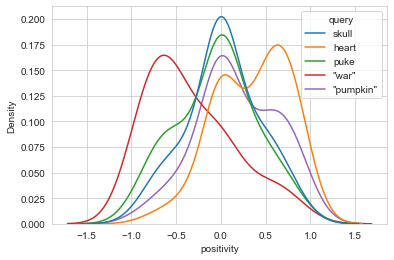

In [32]:
sns.set_style('whitegrid')
sns.kdeplot(data=emoji_df, x='positivity', hue='query', bw=0.5)

### Network

In [14]:
import networkx as nx
from tqdm import tqdm

In [15]:
base_node = api.get_user(screen_name = "DavidCastilloAC")  # stars reporter
base_node.id

330764365

In [16]:
followers = api.get_follower_ids(user_id=330764365)
print(len(followers))

1225


In [17]:
def get_user_positivity(user_id):
    try:
        follower_tweets = get_df(api.user_timeline(
            user_id=user_id, include_rts=False, tweet_mode='extended'
        ))
    except:
        return np.nan
    if follower_tweets.shape[0] == 0:
        return np.nan
    return follower_tweets['positivity'].median()

In [18]:
follower_df = pd.DataFrame({'follower': followers})
print(datetime.datetime.now())
follower_df['median_positivity'] = follower_df['follower'].apply(lambda x: get_user_positivity(x))
print(datetime.datetime.now())

2022-10-26 17:06:19.433879
2022-10-26 17:14:26.491735


In [19]:
follower_df[~follower_df['median_positivity'].isna()]['median_positivity'].median()

0.0

In [15]:
#temp_df = get_df(api.user_timeline(user_id=330764365, include_rts=False, tweet_mode='extended'))